In [1]:
from utils import *

# Hyperparameters etc
device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 128
NUM_EPOCHS = 5
FEATURES_CRITIC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
# WEIGHT_CLIP = 0.01
LAMBDA_GP = 10

transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)
dataset = datasets.MNIST(root = 'data/', train=True, download=False, transform = transforms)


#comment mnist and uncomment below if you want to train on CelebA dataset
#dataset = datasets.ImageFolder(root="celeb_dataset", transform=transforms)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


 11%|█         | 100/938 [00:35<04:56,  2.82it/s]

Epoch [1/5] Batch 100/938                   Loss D: -92.2981, loss G: 86.4441


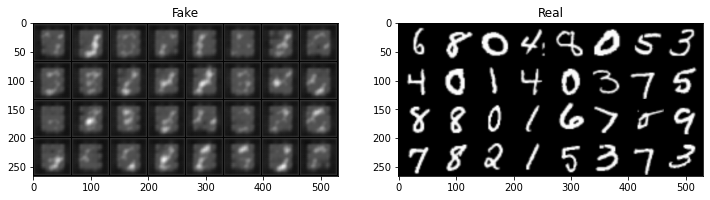

 21%|██▏       | 200/938 [01:11<04:23,  2.80it/s]

Epoch [1/5] Batch 200/938                   Loss D: -67.0816, loss G: 79.1058


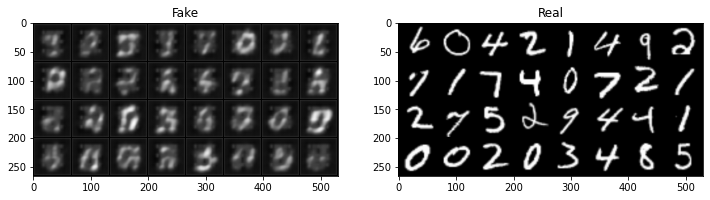

 32%|███▏      | 300/938 [01:47<03:57,  2.69it/s]

Epoch [1/5] Batch 300/938                   Loss D: -46.0798, loss G: 75.1054


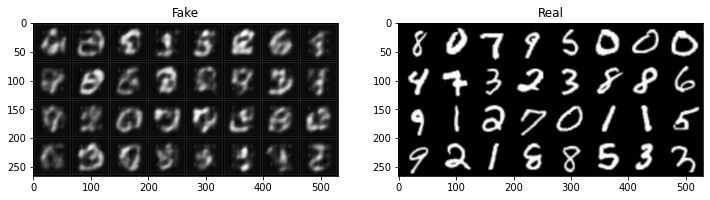

 43%|████▎     | 400/938 [02:23<03:13,  2.78it/s]

Epoch [1/5] Batch 400/938                   Loss D: -33.5199, loss G: 71.2036


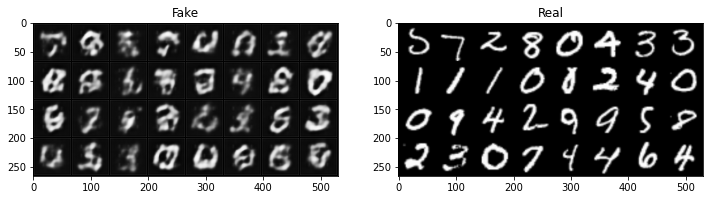

 53%|█████▎    | 500/938 [02:59<02:37,  2.78it/s]

Epoch [1/5] Batch 500/938                   Loss D: -24.4420, loss G: 67.3671


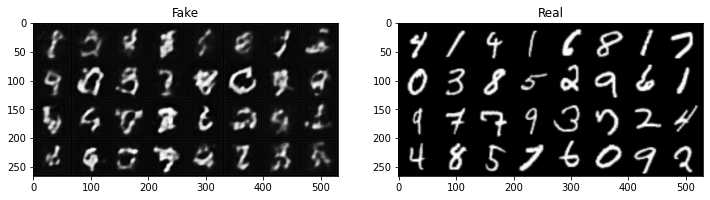

 64%|██████▍   | 600/938 [03:36<02:01,  2.77it/s]

Epoch [1/5] Batch 600/938                   Loss D: -16.2792, loss G: 74.4950


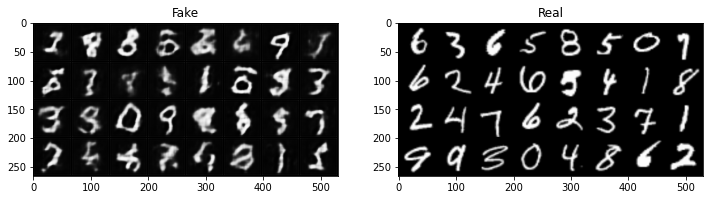

 65%|██████▌   | 611/938 [03:40<01:58,  2.77it/s]


KeyboardInterrupt: 

In [13]:
# initialize gen and disc/critic
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC).to(device)
initialize_weights(gen)
initialize_weights(critic)

# initializate optimizer
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

# for tensorboard plotting
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

gen.train()
critic.train()

for epoch in range(NUM_EPOCHS):
    for batch_idx, (data, _) in enumerate(tqdm(loader)):
        data = data.to(device)
        cur_batch_size = data.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise)
            critic_real = critic(data).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = gradient_penalty(critic,data, fake, device=device)
            
            loss_critic = (-(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP*gp)
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()



        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0 and batch_idx > 0:
            gen.eval()
            critic.eval()
            print(
                f"Epoch [{epoch+1}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(
                    data[:32].cpu().detach(), normalize=True
                )
                img_grid_fake = torchvision.utils.make_grid(
                    fake[:32].cpu().detach(), normalize=True
                )
                fig, ax = plt.subplots(1,2, figsize= (12,6))
                ax[0].imshow(img_grid_fake.permute(1, 2, 0))
                ax[1].imshow(img_grid_real.permute(1,2,0))
                ax[0].set_title('Fake')
                ax[1].set_title('Real')

                plt.show()
                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1
            gen.train()
            critic.train()